In [1]:
import datetime

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import find_crystal_position
from CCfun  import compute_baseline_between

from CCfit  import fit
from CCfit  import polynom
from CCfit  import gauss
from CCfit  import double_gauss

from CCplot import auto_plot_style
from CCplot import plot1d
from CCplot import plot2d

from CCio import load_and_process

In [2]:
%matplotlib inline

auto_plot_style({"lines.linewidth": 2, "font.size":20})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
SPIKES_THRESHOLD = 150

def remove_spikes(data):
    diff    = np.append([0], np.diff(data.counts))
    ok      = diff < SPIKES_THRESHOLD
    counts  = data.counts .where(ok, np.nan)
    bkgsub  = data.bkgsub .where(ok, np.nan)
    rate    = data.rate   .where(ok, np.nan)
    dquanta = data.dquanta.where(ok, np.nan)
    return data.assign(counts  = counts .fillna(method="ffill"),
                       bkgsub  = bkgsub .fillna(method="ffill"),
                       rate    = rate   .fillna(method="ffill"),
                       dquanta = dquanta.fillna(method="ffill"))

def calculate_irradiation_times(dates):
    dates = np.asarray(dates[1:])
    dates = dates.reshape(dates.size // 2, 2)
    return [t[0].total_seconds() / 3600 for t in np.diff(dates, axis=1)]

In [5]:
def double_gauss_poly(x, *args):
    gauss1 = args[0:3]
    gauss2 = args[3:6]
    poly   = args[6: ]
    return double_gauss(x, *gauss1, *gauss2) + polynom(x, *poly)

def triple_gauss_poly(x, *args):
    gauss1 = args[0:3]
    gauss2 = args[3:6]
    gauss3 = args[6:9]
    poly   = args[9: ]
    return double_gauss(x, *gauss1, *gauss2) + gauss(x, *gauss3) + polynom(x, *poly)

# All data

In [6]:
dates = [
datetime.datetime(2020, 4,  1, 22, 30), # Pre scan
datetime.datetime(2020, 4,  2,  7, 55), # Irradiating Crystal 4 (LiF, non-annealed)
datetime.datetime(2020, 4,  5,  1, 15), # Scan LiF crystals (4 and 10)
datetime.datetime(2020, 4,  5,  6, 25), # Irradiating Crystal 4 (LiF, non-annealed)
datetime.datetime(2020, 4,  8, 22, 20), # Scan LiF crystals
datetime.datetime(2020, 4,  9,  3, 30), # Irradiating Crystal 4 (LiF, non-annealed)
datetime.datetime(2020, 4, 11, 14, 26), # Scan LiF crystals
datetime.datetime(2020, 4, 11, 19, 36), # Irradiating Crystal 4 (LiF, non-annealed)
datetime.datetime(2020, 4, 14, 16, 10), # Scan LiF crystals
datetime.datetime(2020, 4, 14, 21, 21), # Irradiating Crystal 4 (LiF, non-annealed)
datetime.datetime(2020, 4, 17, 16, 15), # Scan LiF crystals
datetime.datetime(2020, 4, 17, 21, 24), # Irradiating Crystal 4 (LiF, non-annealed)
datetime.datetime(2020, 4, 20, 12, 44), # Scan LiF crystals
datetime.datetime(2020, 4, 20, 17, 54), # Irradiating Crystal 4 (LiF, non-annealed)
datetime.datetime(2020, 4, 21,  1, 22), # Scan LiF crystals

datetime.datetime(2020, 4, 21,  6, 32), # Irradiating Crystal 10 (LiF, non-annealed)
datetime.datetime(2020, 4, 23, 13, 23), # Scan LiF crystals
datetime.datetime(2020, 4, 23, 18, 33), # Irradiating Crystal 10 (LiF, non-annealed)
datetime.datetime(2020, 4, 25,  0,  3), # Scan LiF crystals
datetime.datetime(2020, 4, 25,  5, 13), # Irradiating Crystal 10 (LiF, non-annealed)
datetime.datetime(2020, 4, 27, 19, 38), # Scan LiF crystals
datetime.datetime(2020, 4, 28,  0, 48), # Irradiating Crystal 10 (LiF, non-annealed)
datetime.datetime(2020, 4, 30,  2, 54), # Scan LiF crystals
datetime.datetime(2020, 4, 30,  8,  4), # Irradiating Crystal 10 (LiF, non-annealed)
datetime.datetime(2020, 5,  3,  1, 56), # Scan LiF crystals
datetime.datetime(2020, 5,  3,  7,  6), # Irradiating Crystal 10 (LiF, non-annealed)
datetime.datetime(2020, 5,  3, 13, 49), # Scan LiF crystals
datetime.datetime(2020, 5,  3, 18, 59), # Irradiating Crystal 10 (LiF, non-annealed)
datetime.datetime(2020, 5,  4,  3, 35), # Scan LiF crystals
datetime.datetime(2020, 5,  4,  8, 45), # Irradiating Crystal 10 (LiF, non-annealed)
datetime.datetime(2020, 5,  6, 12, 46), # Scan LiF crystals
]

irradiation_times = calculate_irradiation_times(dates)

In [7]:
irradiation_times

[65.33333333333333,
 87.91666666666667,
 58.93333333333333,
 68.56666666666666,
 66.9,
 63.333333333333336,
 7.466666666666667,
 54.85,
 29.5,
 62.416666666666664,
 50.1,
 65.86666666666666,
 6.716666666666667,
 8.6,
 52.016666666666666]

In [8]:
filenames = ["/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_01_22_29_22_481800.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_05_01_14_44_624000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_08_22_19_33_248000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_11_14_26_25_444000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_14_16_11_01_628000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_17_16_14_46_087000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_20_12_44_11_235000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_21_01_22_09_296000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_23_13_23_17_384000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_25_00_02_46_010000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_27_19_38_26_589000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_04_30_02_54_18_370000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_05_03_01_55_42_712000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_05_03_13_49_29_815000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_05_04_03_35_05_148000.h5",
             "/home/gonzalo/data/CC/cs137_irrad_v1_2020_05_06_12_46_41_542000.h5",
            ]

dfs = [load_and_process(filename, i).crystals.groupby("state", as_index=False)\
                                             .apply(remove_spikes)\
                                             .reset_index(drop=True)
       for i, filename in enumerate(filenames)]

In [9]:
dfs[0].head()

full_scan  crystal  grating  exp_index  slit_width  state  exposure  ex_wl  \
0       True        4        2          0        1000     59       0.2  800.0   
1       True        4        2          0        1000     59       0.2  800.0   
2       True        4        2          0        1000     59       0.2  800.0   
3       True        4        2          0        1000     59       0.2  800.0   
4       True        4        2          0        1000     59       0.2  800.0   

          power           timestamp  em_wl  counts  crystal_id crystal_type  \
0  6.415346e-07 2020-04-01 21:25:22  833.5  3071.0  LiF_B1_121          LiF   
1  6.415346e-07 2020-04-01 21:25:22  834.0  3068.0  LiF_B1_121          LiF   
2  6.415346e-07 2020-04-01 21:25:22  834.5  3065.0  LiF_B1_121          LiF   
3  6.415346e-07 2020-04-01 21:25:22  835.0  3053.0  LiF_B1_121          LiF   
4  6.415346e-07 2020-04-01 21:25:22  835.5  3054.0  LiF_B1_121          LiF   

   bkgsub   rate       quantar       dquanta  wheel_no  
0     1.0    5.0  2.583933e+14  1.935035e-14         0  
1    -7.0  -35.0  2.583933e+14 -1.354524e-13         0  
2     7.0   35.0  2.583933e+14  1.354524e-13         0  
3   -29.0 -145.0  2.583933e+14 -5.611601e-13         0  
4   -20.0 -100.0  2.583933e+14 -3.870070e-13         0

# All wavelengths

# 440 nm

In [10]:
plt.figure(figsize=(12, 5))

data = filter_df(dfs[-1], crystal=4, grating=2, exposure=10, ex_wl=440)
plt.plot(data.em_wl, data.dquanta, drawstyle="steps")
plt.xlabel("em wl (nm)")
plt.ylabel("qduanta (ph/ph)")

Text(0, 0.5, 'qduanta (ph/ph)')

In [11]:
nhalf = int(np.ceil(len(dfs)/2))

plt.figure(figsize=(10*2, 6*nhalf))

fit_values = []

for n, df in enumerate(dfs, start=1):
    data = filter_df(df, crystal=4, grating=2, exposure=10, ex_wl=440)
    data = data[~in_range(data.em_wl, 930, 1000)]
    low  = 1e-16, 500, 20,    1e-16, 600, 40,       0 
    seed = 1e-12, 525, 30,    1e-12, 650, 65,       1e-16
    upp  = 1e-10, 550, 50,    1e-10, 675, 80,       1e-15 

    f    = fit(double_gauss_poly, data.em_wl.values, data.dquanta.values,
               seed      = seed,
               maxfev    = 10**5)
    
    fit_values.append(f.values)
    
    plt.subplot(nhalf, 2, n)
    plt.plot(data.em_wl, data.dquanta, label=str(n), drawstyle="steps")
    plt.plot(data.em_wl, f.fn(data.em_wl), "r-")
    plt.text(0.5, 0.5, " ".join(["$\mu$ = "] + ["{:.0f}".format(x) for x in f.values[1::3]] ), transform=plt.gca().transAxes)
    
    plt.xlabel("em wl (nm)")
    plt.ylabel("qduanta (ph/ph)")
    plt.title (str(n))

plt.tight_layout()

fit_values = np.stack(fit_values)

In [12]:
irrad_time  = np.cumsum(np.append([0], irradiation_times))
a1, m1, s1, a2, m2, s2, c = fit_values.T 

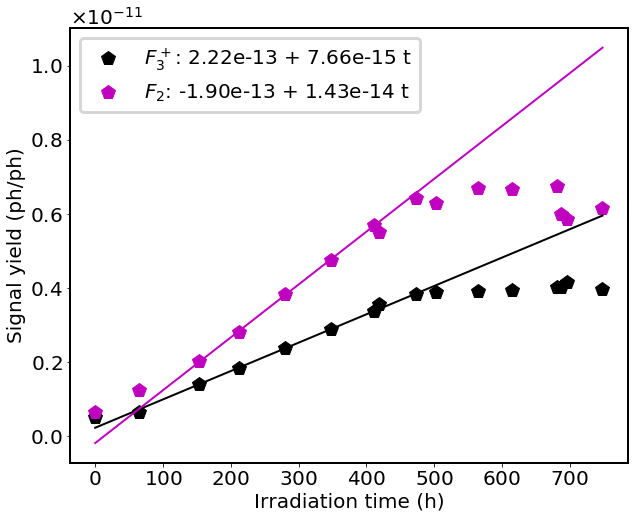

In [13]:
s  = slice(2, 7)
f1 = fit(polynom, irrad_time[s], a1[s], (0, 1))
f2 = fit(polynom, irrad_time[s], a2[s], (0, 1))

plt.plot(irrad_time, a1, "p", label=f"$F_3^+$: {f1.values[0]:.2e} + {f1.values[1]:.2e} t")
plt.plot(irrad_time, a2, "p", label=f"$F_2 $: {f2.values[0]:.2e} + {f2.values[1]:.2e} t")

plt.plot(irrad_time, f1.fn(irrad_time), "-k")
plt.plot(irrad_time, f2.fn(irrad_time), "-m")

plt.xlabel("Irradiation time (h)")
plt.ylabel("Signal yield (ph/ph)")
plt.legend()

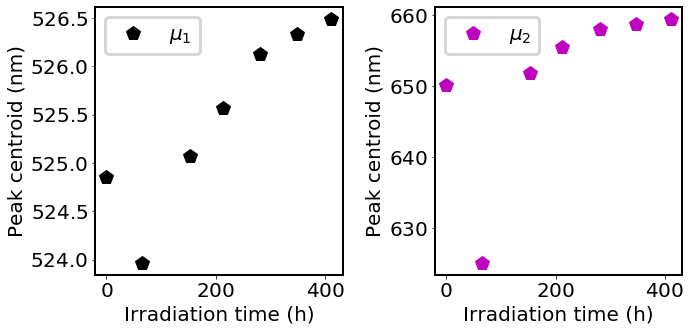

In [14]:
s = slice(7)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(irrad_time[s], m1[s], "pk", label="$\mu_1$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(irrad_time[s], m2[s], "pm", label="$\mu_2$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak centroid (nm)")
plt.legend()

plt.tight_layout()

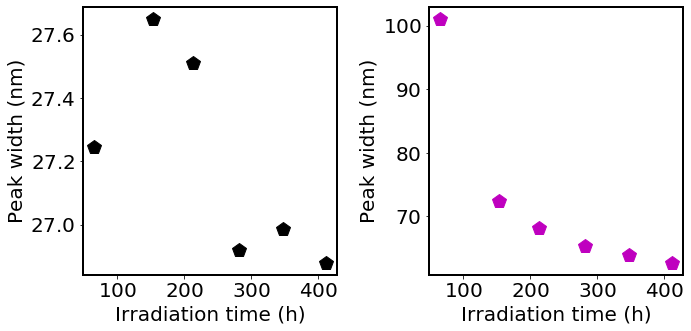

In [15]:
s = slice(1, 7)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(irrad_time[s], s1[s], "pk", label="$\sigma_1$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

plt.subplot(1, 2, 2)
plt.plot(irrad_time[s], s2[s], "pm", label="$\sigma_2$")
plt.xlabel("Irradiation time (h)")
plt.ylabel("Peak width (nm)")

plt.tight_layout()

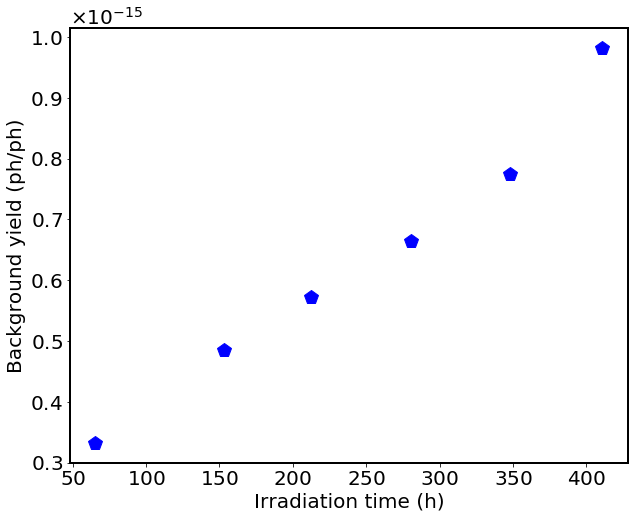

In [16]:
plt.plot(irrad_time[s], c[s], "pb")

plt.xlabel("Irradiation time (h)")
plt.ylabel("Background yield (ph/ph)");